In [1]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 26px;
</style>

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
suffix = '_16node_128latent_1step'

In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
# warnings.filterwarnings('ignore')

In [5]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
    # logical_gpus = tf.config.list_logical_devices('GPU')
    # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2023-09-25 14:41:32.721366: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-25 14:41:32.816865: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Parameter data

In [6]:
import numpy as np
import os

node_num = 16
training_id = 0
check_point = 250
end_point = 280

folder_path = os.path.join(os.getcwd(), '../learn_output')
file_path = os.path.join(folder_path, 'weight50_%d_%d.npy' % (node_num, training_id))

weight = np.load(file_path, allow_pickle=True)

x_train_para = weight[:-1,:]
y_train_para = weight[1:,:]

for training_id in range(1, check_point):
    file_path = os.path.join(folder_path, 'weight50_%d_%d.npy' % (node_num, training_id))
    
    weight = np.load(file_path, allow_pickle=True)
    
    x_train_para = np.concatenate((x_train_para, weight[:-1,:]), axis = 0)
    y_train_para = np.concatenate((y_train_para, weight[1:,:]), axis = 0)

training_id = check_point
file_path = os.path.join(folder_path, 'weight50_%d_%d.npy' % (node_num, training_id))
weight = np.load(file_path, allow_pickle=True)

x_test_para = weight[:-1,:]
y_test_para = weight[1:,:]

for training_id in range(check_point + 1, end_point):
    file_path = os.path.join(folder_path, 'weight50_%d_%d.npy' % (node_num, training_id))
    
    weight = np.load(file_path, allow_pickle=True)
    
    x_test_para = np.concatenate((x_test_para, weight[:-1,:]), axis = 0)
    y_test_para = np.concatenate((y_test_para, weight[1:,:]), axis = 0)


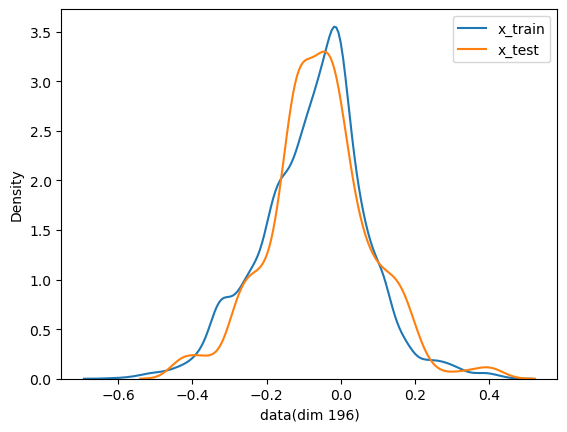

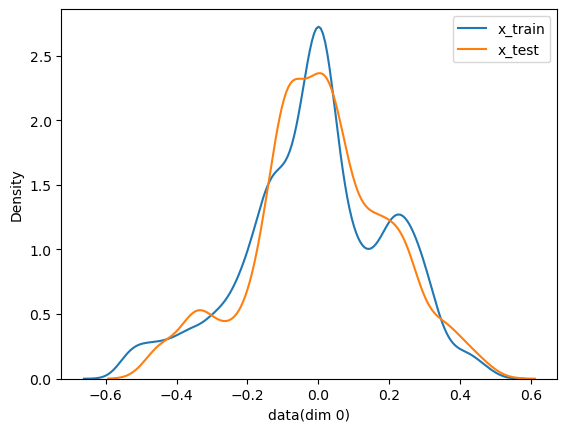

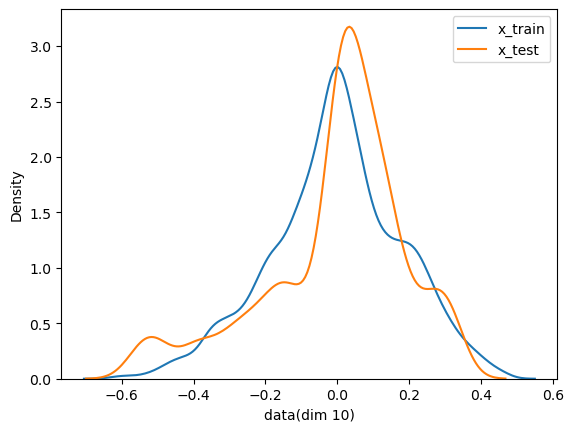

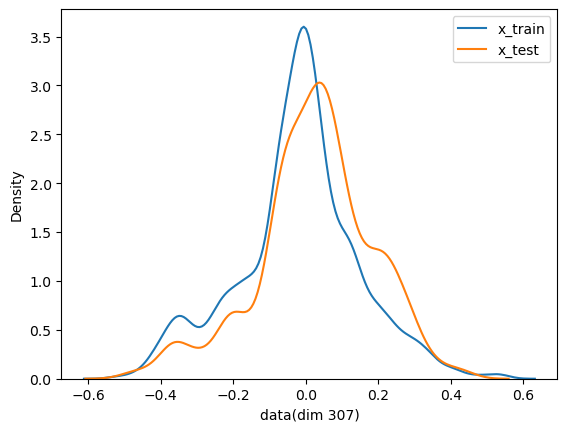

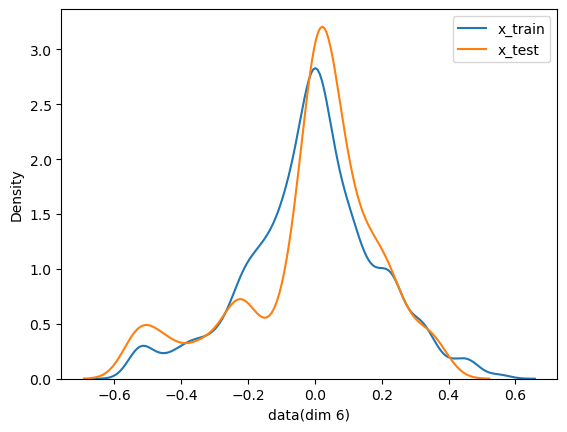

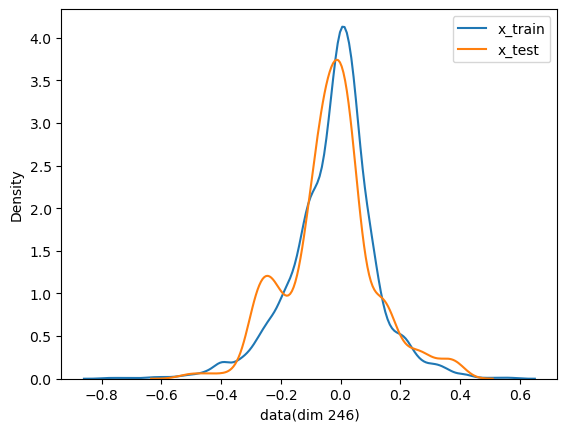

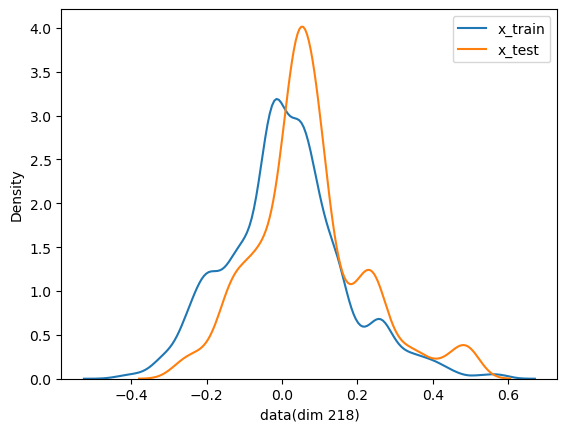

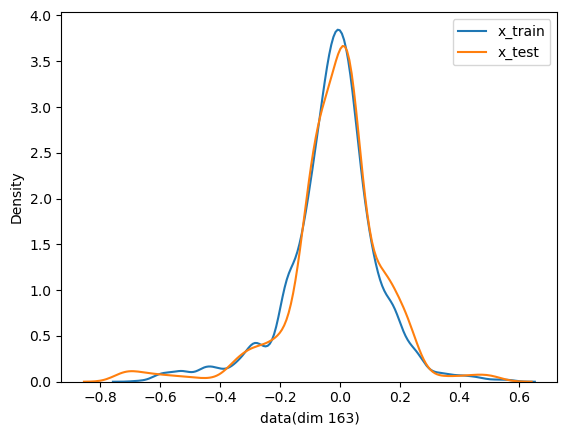

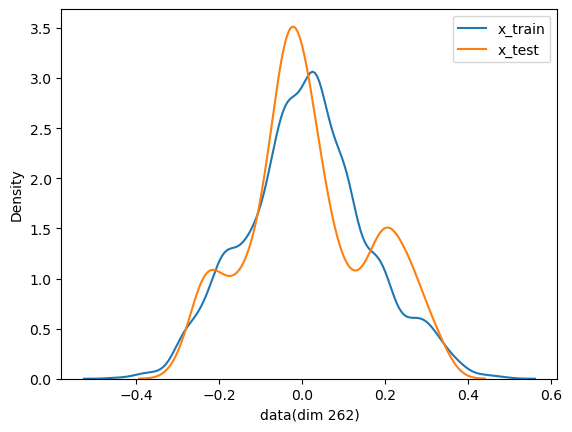

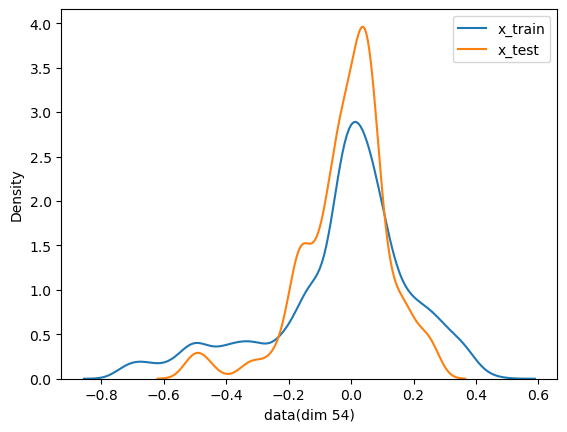

[196, 0, 10, 307, 6, 246, 218, 163, 262, 54]


In [7]:
# Distribution
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

random_numbers = []

for i in range(10):
    random_numbers.append(random.randint(0, 465))
    random_number = random_numbers[-1]
    sns.kdeplot(x_train_para[:, random_number], label = 'x_train')
    sns.kdeplot(x_test_para[:, random_number], label = 'x_test')
    plt.xlabel('data(dim %d)' % random_number)
    plt.legend()
    plt.show()

print(random_numbers)

In [8]:
permuted_indices = np.random.permutation(x_train_para.shape[0])
x_train_para = x_train_para[permuted_indices, :]
y_train_para = y_train_para[permuted_indices, :]


In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train_para)
x_train_para_scaled = scaler.transform(x_train_para)
y_train_para_scaled = scaler.transform(y_train_para)
x_test_para_scaled = scaler.transform(x_test_para)
y_test_para_scaled = scaler.transform(y_test_para)

## Mnist Data and Model

In [10]:
from sklearn.decomposition import PCA

# Load MNIST data.
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = tf.keras.datasets.mnist.load_data()

# Preprocessing: normalize pixel values to be between 0 and 1.
x_train_mnist = x_train_mnist / 255.0
x_test_mnist = x_test_mnist / 255.0

# Shuffle training data.
shuffle_index = np.random.permutation(len(x_train_mnist))
x_train_mnist, y_train_mnist = x_train_mnist[shuffle_index], y_train_mnist[shuffle_index]

# Convert target labels to binary classification (digit < 5 or digit >= 5).
y_train_mnist = (y_train_mnist < 5)
y_test_mnist = (y_test_mnist < 5)

# Convert labels to one-hot encoding.
y_train_mnist = tf.keras.utils.to_categorical(y_train_mnist)
y_test_mnist = tf.keras.utils.to_categorical(y_test_mnist)

# Instantiate the training dataset.
x_train_mnist = np.reshape(x_train_mnist, (-1, 784))
x_test_mnist = np.reshape(x_test_mnist, (-1, 784))

# Perform PCA to reduce dimensionality of x_train.
pca = PCA(n_components=0.7)  # retain 95% of variance
x_train_reduced_mnist = pca.fit_transform(x_train_mnist.reshape(x_train_mnist.shape[0], -1))
x_test_reduced_mnist = pca.transform(x_test_mnist.reshape(x_test_mnist.shape[0], -1))

In [11]:
x_combined_reduced_mnist = np.concatenate((x_train_reduced_mnist, x_test_reduced_mnist), axis=0)
y_combined_reduced_mnist = np.concatenate((y_train_mnist, y_test_mnist), axis=0)

In [12]:
from tensorflow import keras

inputs = keras.Input(shape=(26,), name="digits")
x = keras.layers.Dense(node_num, activation="relu", kernel_initializer="uniform",bias_initializer="uniform")(inputs)
outputs = keras.layers.Dense(2, name="predictions",kernel_initializer="uniform",bias_initializer="uniform")(x)
model_mnist = keras.Model(inputs=inputs, outputs=outputs, name = 'model_mnist')

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
# Instantiate a loss function.
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
# Compile the model
model_mnist.compile(optimizer=optimizer, loss=loss_fn,  metrics=["accuracy"])

2023-09-25 14:41:46.604170: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-25 14:41:47.076731: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19888 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:c3:00.0, compute capability: 8.6


In [13]:
model_mnist.summary()

Model: "model_mnist"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 digits (InputLayer)         [(None, 26)]              0         
                                                                 
 dense (Dense)               (None, 16)                432       
                                                                 
 predictions (Dense)         (None, 2)                 34        
                                                                 
Total params: 466
Trainable params: 466
Non-trainable params: 0
_________________________________________________________________


## Parameter Model

In [14]:
# Build the model
from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras.layers import Input, Add, Multiply, Lambda, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
import numpy as np
import tensorflow as tf
from tensorflow import keras
tf.executing_eagerly()

class DicNN(Layer):
    """
    Trainable disctionries
    """
    
    def __init__(self, n_input, layer_sizes=[64,64], n_psi_train=64, **kwargs):
        """_summary_
        Args:
            layer_sizes (list, optional): Number of unit of hidden layer, activation = 'tanh'. Defaults to [64, 64].
            n_psi_train (int, optional): Number of unit of output layer. Defaults to 22.
        """
        super(DicNN, self).__init__(**kwargs)
        self.layer_sizes = layer_sizes
        self.input_layer = Dense(self.layer_sizes[0], name='Dic_input', use_bias=False)
        self.hidden_layers = [Dense(layer_sizes[i], activation='tanh', name='Dic_hidden_%d'%i) for i in range(len(layer_sizes))]        
        self.output_layer = Dense(n_psi_train, name='Dic_output')
        self.n_psi_train = n_psi_train
        self.inv_input_layer = Dense(self.layer_sizes[-1], name = 'Dic_input_inv', use_bias=False)
        self.inv_hidden_layers = [Dense(layer_sizes[-(i+1)], activation='tanh', name='Dic_hidden_%d_inv'%i) for i in range(len(layer_sizes))]
        self.inv_output_layer = Dense(n_input, name = 'Dic_output_inv')
        self.n_input = n_input
        
    def call(self, inputs):
        psi_x_train = self.input_layer(inputs)
        for layer in self.hidden_layers:
            psi_x_train = psi_x_train + layer(psi_x_train)
        outputs = self.output_layer(psi_x_train)
        return outputs
    
    def inv_call(self, inputs):
        x_inv = self.inv_input_layer(inputs)
        for layer in self.inv_hidden_layers:
            x_inv = x_inv + layer(x_inv)
        outputs = self.inv_output_layer(x_inv)
        return outputs
    
    def get_config(self):
        config = super(DicNN, self).get_config()
        config.update({
            'layer_sizes': self.layer_sizes,
            'n_psi_train': self.n_psi_train
        })
        return config

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Layer, Subtract
from tensorflow.keras.models import Model

class CustomLayer(tf.keras.layers.Layer):
    def __init__(self, weights_shape, biases_shape, **kwargs):
        super(CustomLayer, self).__init__(**kwargs)
        self.weights_shape = weights_shape
        self.biases_shape = biases_shape

    def call(self, x, theta_w, theta_b, m):
        x = tf.cast(x, dtype=tf.float32)
        w = tf.reshape(theta_w, self.weights_shape)
        b = tf.reshape(theta_b, self.biases_shape)
        b_expanded = tf.tile(tf.expand_dims(b, axis=1), [1, m, 1])
        y = tf.matmul(x, w) + b_expanded
        return y

class ModelLayer(tf.keras.layers.Layer):
    def __init__(self, model, data, **kwargs):
        super(ModelLayer, self).__init__(**kwargs)
        self.model = model
        self.data = data
        self.layer_shape = []
        self.layer_size = []
        self.m = np.shape(data)[0]
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:
                weights_shape = tf.shape(weights[0])
                biases_shape = tf.shape(weights[1])
                target_shapes = [weights_shape, biases_shape]
                target_shapes = [tf.concat([[-1], shape], axis=0) for shape in target_shapes]
                weights_size = tf.size(weights[0]).numpy()
                biases_size = tf.size(weights[1]).numpy()
                self.layer_shape.append(target_shapes)
                self.layer_size.append([weights_size, biases_size])            
            print(self.layer_shape)
            print(self.layer_size)
        
        self.Layers = []
        for shape in self.layer_shape:
            if shape != None:
                self.Layers.append(CustomLayer(shape[0], shape[1]))
                
    def call(self, theta_M):
        index = 0
        y = self.data
                
        # Hidden Layers
        for i in range(len(self.layer_shape) - 1):
#             print(index)
            size = self.layer_size[i]
            theta_w = theta_M[:, index:index + size[0]]
            theta_b = theta_M[:, index + size[0]: index + size[0] + size[1]]
            index += size[0] + size[1]
            y = self.Layers[i].call(y, theta_w, theta_b, self.m)
            y = tf.nn.relu(y)
        
        # Output Layer
        size = self.layer_size[-1]
        size1 = index + size[0]
#         print(size1)
        theta_w = theta_M[:, index:index + size[0]]
        theta_b = theta_M[:, index + size[0]: index + size[0] + size[1]]
        y = self.Layers[-1].call(y, theta_w, theta_b, self.m)
        return y

In [16]:
# layer_f
Layer_f = ModelLayer(model_mnist, x_train_reduced_mnist)

ListWrapper([])
ListWrapper([])
ListWrapper([ListWrapper([<tf.Tensor: shape=(3,), dtype=int32, numpy=array([-1, 26, 16], dtype=int32)>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([-1, 16], dtype=int32)>])])
ListWrapper([ListWrapper([416, 16])])
ListWrapper([ListWrapper([<tf.Tensor: shape=(3,), dtype=int32, numpy=array([-1, 26, 16], dtype=int32)>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([-1, 16], dtype=int32)>]), ListWrapper([<tf.Tensor: shape=(3,), dtype=int32, numpy=array([-1, 16,  2], dtype=int32)>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([-1,  2], dtype=int32)>])])
ListWrapper([ListWrapper([416, 16]), ListWrapper([32, 2])])


In [17]:
def Build_model(x_train_para = x_train_para, n_psi_train = 64):
    # model_psi
    dic = DicNN(n_input = np.shape(x_train_para)[1], n_psi_train = n_psi_train)
    inputs_x = Input((np.shape(x_train_para)[1],))
    model_psi = Model(inputs = inputs_x, outputs = dic.call(inputs_x), name = 'model_psi')
    
    # model_koopman
    inputs_x = Input((np.shape(x_train_para)[1],))
    psi_x = model_psi(inputs_x)
    k_layer = Dense(units = dic.n_psi_train, use_bias=False, name = 'k_layer')
    outputs_x = k_layer(psi_x)
    inputs_y = Input((np.shape(x_train_para)[1],))
    psi_y = model_psi(inputs_y)
    outputs = outputs_x - psi_y
    model_koopman = Model(inputs = [inputs_x, inputs_y], outputs = outputs, name = 'model_koopman')
    
    # model_inverse
    inputs_kpsi = Input((dic.n_psi_train,))
    model_inv_psi = Model(inputs = inputs_kpsi, outputs = dic.inv_call(inputs_kpsi), name = 'model_psi_inv')
    
    # model_predict
    inputs_x = Input((np.shape(x_train_para)[1],))
    psi_x = model_psi(inputs_x)
    psi_x_predict = k_layer(psi_x)
    outputs_predict = model_inv_psi(psi_x_predict)
    model_predict = Model(inputs = inputs_x, outputs = outputs_predict, name = 'model_predict')
    
    # autoencoder
    input_x = tf.keras.layers.Input(shape=(x_train_para.shape[1],))
    psi_x = model_psi(inputs_x)
    x_hat = model_inv_psi(psi_x)
    model_auto = Model(inputs = inputs_x, outputs = x_hat, name = 'model_auto')

    return model_psi, model_koopman, model_inv_psi, model_predict, model_auto

In [18]:
model_psi, model_koopman, model_inv_psi, model_predict, model_auto = Build_model(x_train_para = x_train_para, n_psi_train = 128)

In [19]:
model_predict.summary()

Model: "model_predict"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 466)]             0         
                                                                 
 model_psi (Functional)      (None, 128)               46464     
                                                                 
 k_layer (Dense)             (None, 128)               16384     
                                                                 
 model_psi_inv (Functional)  (None, 466)               46802     
                                                                 
Total params: 109,650
Trainable params: 109,650
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Create a train_dataset using from_tensor_slices
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_para, y_train_para))
val_dataset = tf.data.Dataset.from_tensor_slices((x_test_para, y_test_para))


# Shuffle and batch the dataset (you can adjust batch_size and buffer_size as needed)
batch_size = 1024
buffer_size = 10000
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size).batch(batch_size)


# Optionally, you can prefetch data for faster training
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


In [21]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Define the optimizer
optimizer = Adam(learning_rate=0.001)  # Set the learning rate as needed

# Define the Mean Squared Error loss function
def MeanSquaredError():
    return tf.keras.losses.MeanSquaredError()

# Define the loss function (as you've defined previously)
lambda_1 = 10.0
lambda_2 = 0.1
lambda_3 = 0.1

# Get the list of trainable variables
trainable_variables = model_koopman.trainable_variables + model_predict.trainable_variables + model_auto.trainable_variables

# Define a function to compute and apply gradients
@tf.function
def train_step(x_data, y_data):
    with tf.GradientTape() as tape:
        # Calculate the loss
        koopman_loss = MeanSquaredError()(tf.zeros_like(model_psi(x_data)), model_koopman([x_data, y_data]))
        predicted_y = Layer_f(model_predict(x_data))
        reconstruction_loss = MeanSquaredError()(predicted_y, Layer_f(y_data))
        autoencoder_loss = MeanSquaredError()(Layer_f(model_auto(x_data)), Layer_f(x_data))
        total_loss = lambda_1 * koopman_loss + lambda_2 * reconstruction_loss + lambda_3 * autoencoder_loss

    # Compute gradients
    gradients = tape.gradient(total_loss, trainable_variables)

    # Apply gradients to update model parameters
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    
    return total_loss, koopman_loss, reconstruction_loss, autoencoder_loss

# Define a function to compute loss on validation data
@tf.function
def validate_step(x_data, y_data):
    # Calculate the loss
    koopman_loss = MeanSquaredError()(tf.zeros_like(model_psi(x_data)), model_koopman([x_data, y_data]))
    predicted_y = Layer_f(model_predict(x_data))
    reconstruction_loss = MeanSquaredError()(predicted_y, Layer_f(y_data))
    autoencoder_loss = MeanSquaredError()(Layer_f(model_auto(x_data)), Layer_f(x_data))
    total_loss = lambda_1 * koopman_loss + lambda_2 * reconstruction_loss + lambda_3 * autoencoder_loss
    
    return total_loss, koopman_loss, reconstruction_loss, autoencoder_loss

In [22]:
# Initialize lists to store training and validation losses for each component
train_koopman_losses_per_epoch = []
train_autoencoder_losses_per_epoch = []
train_reconstruction_losses_per_epoch = []
val_koopman_losses_per_epoch = []
val_autoencoder_losses_per_epoch = []
val_reconstruction_losses_per_epoch = []
train_losses_per_epoch = []
val_losses_per_epoch = []

# Perform validation after each training epoch
num_epochs = 100
for epoch in range(num_epochs):
    total_loss_epoch = 0.0
    
    # Initialize epoch-specific loss variables for each component
    koopman_loss_epoch = 0.0
    autoencoder_loss_epoch = 0.0
    reconstruction_loss_epoch = 0.0
    
    # Training loop (similar to your code)
    for batch_x_data, batch_y_data in train_dataset:
        loss, koopman_loss, reconstruction_loss, autoencoder_loss = train_step(batch_x_data, batch_y_data)
        total_loss_epoch += loss.numpy()
        
        # Accumulate losses for each component
        koopman_loss_epoch += koopman_loss.numpy()
        autoencoder_loss_epoch += autoencoder_loss.numpy()
        reconstruction_loss_epoch += reconstruction_loss.numpy()
    
    # Calculate the average training loss for the epoch (similar to your code)
    avg_loss_epoch = total_loss_epoch / len(train_dataset)
    
    # Validation loop
    total_val_loss_epoch = 0.0
    koopman_val_loss_epoch = 0.0
    autoencoder_val_loss_epoch = 0.0
    reconstruction_val_loss_epoch = 0.0
    
    for batch_x_val_data, batch_y_val_data in val_dataset:
        val_loss, koopman_val_loss, reconstruction_val_loss, autoencoder_val_loss = validate_step(batch_x_val_data, batch_y_val_data)
        total_val_loss_epoch += val_loss.numpy()
        
        # Accumulate validation losses for each component
        koopman_val_loss_epoch += koopman_val_loss.numpy()
        autoencoder_val_loss_epoch += autoencoder_val_loss.numpy()
        reconstruction_val_loss_epoch += reconstruction_val_loss.numpy()
    
    # Calculate the average validation loss for the epoch
    avg_val_loss_epoch = total_val_loss_epoch / len(val_dataset)
    
    # Append the training and validation losses for each component to their respective lists
    train_koopman_losses_per_epoch.append(koopman_loss_epoch / len(train_dataset))
    train_autoencoder_losses_per_epoch.append(autoencoder_loss_epoch / len(train_dataset))
    train_reconstruction_losses_per_epoch.append(reconstruction_loss_epoch / len(train_dataset))
    
    val_koopman_losses_per_epoch.append(koopman_val_loss_epoch / len(val_dataset))
    val_autoencoder_losses_per_epoch.append(autoencoder_val_loss_epoch / len(val_dataset))
    val_reconstruction_losses_per_epoch.append(reconstruction_val_loss_epoch / len(val_dataset))
    
    train_losses_per_epoch.append(avg_loss_epoch)
    val_losses_per_epoch.append(avg_val_loss_epoch)

    # Print both training and validation loss for each epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {avg_loss_epoch}, Val Loss: {avg_val_loss_epoch}, "
          f"Train Koopman Loss: {train_koopman_losses_per_epoch[-1]}, Val Koopman Loss: {val_koopman_losses_per_epoch[-1]}, "
          f"Train Autoencoder Loss: {train_autoencoder_losses_per_epoch[-1]}, Val Autoencoder Loss: {val_autoencoder_losses_per_epoch[-1]}, "
          f"Train Reconstruction Loss: {train_reconstruction_losses_per_epoch[-1]}, Val Reconstruction Loss: {val_reconstruction_losses_per_epoch[-1]}")

# Once training is complete, your model is trained, and you have lists for each component's training and validation losses.


2023-09-25 14:41:51.606371: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-25 14:41:52.127011: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f5c7c01a110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-25 14:41:52.127036: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-09-25 14:41:52.130938: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-25 14:41:52.230165: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1/100, Train Loss: 1.9131268163522084, Val Loss: 0.9548377692699432, Train Koopman Loss: 0.09530186870445807, Val Koopman Loss: 0.0360331479460001, Train Autoencoder Loss: 4.647562821706136, Val Autoencoder Loss: 2.7933263778686523, Train Reconstruction Loss: 4.953517595926921, Val Reconstruction Loss: 3.1517363786697388
Epoch 2/100, Train Loss: 0.5434516121943792, Val Loss: 0.4523475617170334, Train Koopman Loss: 0.016032193865006168, Val Koopman Loss: 0.020650213584303856, Train Autoencoder Loss: 1.8853289783000946, Val Autoencoder Loss: 1.2147101759910583, Train Reconstruction Loss: 1.9459677636623383, Val Reconstruction Loss: 1.243744134902954
Epoch 3/100, Train Loss: 0.29954897860685986, Val Loss: 0.36415858566761017, Train Koopman Loss: 0.009346086260241767, Val Koopman Loss: 0.015480546280741692, Train Autoencoder Loss: 0.9720328052838644, Val Autoencoder Loss: 1.0254339575767517, Train Reconstruction Loss: 1.0888483971357346, Val Reconstruction Loss: 1.0680971145629883
Ep

Epoch 26/100, Train Loss: 0.046257734298706055, Val Loss: 0.08627501875162125, Train Koopman Loss: 0.00042181797228598345, Val Koopman Loss: 0.0018509580404497683, Train Autoencoder Loss: 0.20712165037790933, Val Autoencoder Loss: 0.3487694561481476, Train Reconstruction Loss: 0.2132738915582498, Val Reconstruction Loss: 0.32888492941856384
Epoch 27/100, Train Loss: 0.04676601756364107, Val Loss: 0.07161935791373253, Train Koopman Loss: 0.0004147417057538405, Val Koopman Loss: 0.0017658156575635076, Train Autoencoder Loss: 0.21167535210649172, Val Autoencoder Loss: 0.27520716190338135, Train Reconstruction Loss: 0.2145106407503287, Val Reconstruction Loss: 0.26440487802028656
Epoch 28/100, Train Loss: 0.045354606583714485, Val Loss: 0.06456011906266212, Train Koopman Loss: 0.0003830062535901864, Val Koopman Loss: 0.0016570109291933477, Train Autoencoder Loss: 0.20359200860063234, Val Autoencoder Loss: 0.24888911098241806, Train Reconstruction Loss: 0.21165342504779497, Val Reconstructi

Epoch 50/100, Train Loss: 0.03371321720381578, Val Loss: 0.05339165776968002, Train Koopman Loss: 0.00014723891217727214, Val Koopman Loss: 0.0007209267641883343, Train Autoencoder Loss: 0.15935174375772476, Val Autoencoder Loss: 0.23900362104177475, Train Reconstruction Loss: 0.16305652633309364, Val Reconstruction Loss: 0.22282025963068008
Epoch 51/100, Train Loss: 0.033614689173797764, Val Loss: 0.0535231065005064, Train Koopman Loss: 0.0001406320928557155, Val Koopman Loss: 0.000704324251273647, Train Autoencoder Loss: 0.159029151002566, Val Autoencoder Loss: 0.24046162515878677, Train Reconstruction Loss: 0.16305452957749367, Val Reconstruction Loss: 0.22433701157569885
Epoch 52/100, Train Loss: 0.03415219516803821, Val Loss: 0.06108354777097702, Train Koopman Loss: 0.00013877488891012035, Val Koopman Loss: 0.0006859508284833282, Train Autoencoder Loss: 0.16141115501523018, Val Autoencoder Loss: 0.2780005931854248, Train Reconstruction Loss: 0.16623330488801003, Val Reconstruction

Epoch 74/100, Train Loss: 0.02771059423685074, Val Loss: 0.050518086180090904, Train Koopman Loss: 9.054943438968621e-05, Val Koopman Loss: 0.0003823417500825599, Train Autoencoder Loss: 0.1320746180911859, Val Autoencoder Loss: 0.24250668287277222, Train Reconstruction Loss: 0.1359763741493225, Val Reconstruction Loss: 0.22444000095129013
Epoch 75/100, Train Loss: 0.02810964562619726, Val Loss: 0.05122925341129303, Train Koopman Loss: 7.970355727593414e-05, Val Koopman Loss: 0.00037765607703477144, Train Autoencoder Loss: 0.13447967792550722, Val Autoencoder Loss: 0.24415532499551773, Train Reconstruction Loss: 0.13864642505844435, Val Reconstruction Loss: 0.2303716093301773
Epoch 76/100, Train Loss: 0.028853116712222498, Val Loss: 0.05820467323064804, Train Koopman Loss: 8.628677399732017e-05, Val Koopman Loss: 0.0003794875228777528, Train Autoencoder Loss: 0.1378256157040596, Val Autoencoder Loss: 0.28182923793792725, Train Reconstruction Loss: 0.1420768710474173, Val Reconstruction

Epoch 98/100, Train Loss: 0.025268033302078646, Val Loss: 0.041689008474349976, Train Koopman Loss: 5.796211826236686e-05, Val Koopman Loss: 0.00022521916980622336, Train Autoencoder Loss: 0.12162097419301669, Val Autoencoder Loss: 0.20073745399713516, Train Reconstruction Loss: 0.12526314270993075, Val Reconstruction Loss: 0.19363074004650116
Epoch 99/100, Train Loss: 0.0258511109277606, Val Loss: 0.04877212643623352, Train Koopman Loss: 5.6320764694343474e-05, Val Koopman Loss: 0.00023106257140170783, Train Autoencoder Loss: 0.12478895423312981, Val Autoencoder Loss: 0.2372565045952797, Train Reconstruction Loss: 0.12809007366498312, Val Reconstruction Loss: 0.22735849767923355
Epoch 100/100, Train Loss: 0.027194509282708168, Val Loss: 0.057713888585567474, Train Koopman Loss: 6.0324494067269065e-05, Val Koopman Loss: 0.00022288568288786337, Train Autoencoder Loss: 0.1304536151389281, Val Autoencoder Loss: 0.28554950654506683, Train Reconstruction Loss: 0.13545902321736017, Val Recon

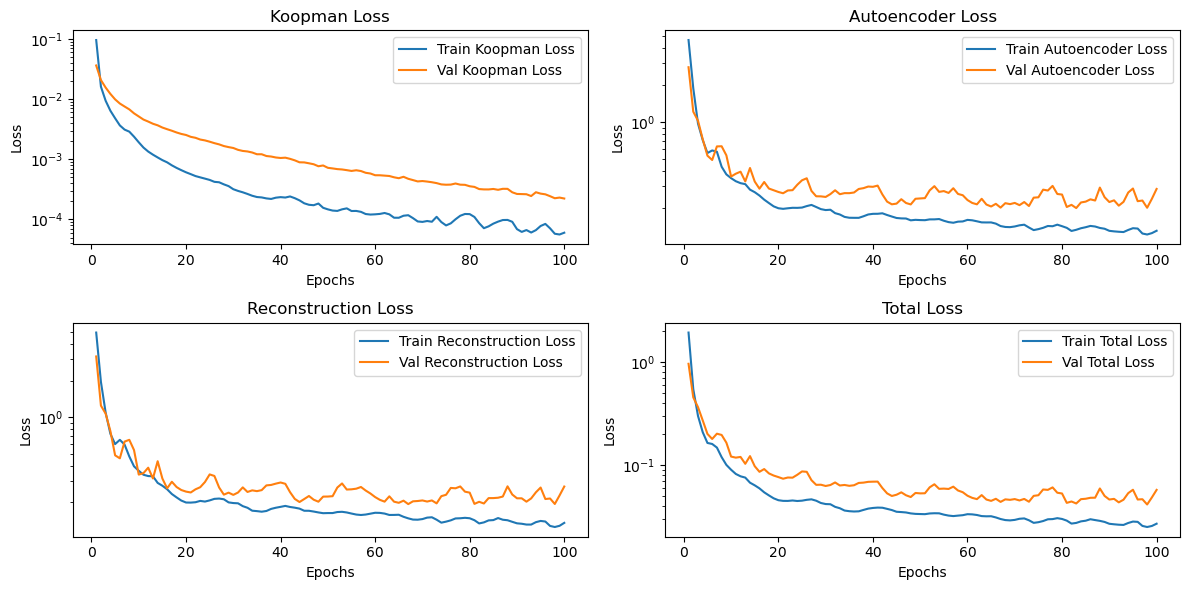

In [23]:
import matplotlib.pyplot as plt

# Assuming you have populated the lists with your data

# Define the x-axis values (epochs)
epochs = range(1, num_epochs + 1)

# Plot the training and validation losses for each component
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_koopman_losses_per_epoch, label='Train Koopman Loss')
plt.plot(epochs, val_koopman_losses_per_epoch, label='Val Koopman Loss')
plt.title('Koopman Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')  # Set y-axis to log scale
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, train_autoencoder_losses_per_epoch, label='Train Autoencoder Loss')
plt.plot(epochs, val_autoencoder_losses_per_epoch, label='Val Autoencoder Loss')
plt.title('Autoencoder Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')  # Set y-axis to log scale
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, train_reconstruction_losses_per_epoch, label='Train Reconstruction Loss')
plt.plot(epochs, val_reconstruction_losses_per_epoch, label='Val Reconstruction Loss')
plt.title('Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')  # Set y-axis to log scale
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, train_losses_per_epoch, label='Train Total Loss')
plt.plot(epochs, val_losses_per_epoch, label='Val Total Loss')
plt.title('Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')  # Set y-axis to log scale
plt.legend()

plt.tight_layout()
plt.show()


In [24]:
# Specify the path where you want to save the weights
weights_filename = 'model_parameter' + suffix + '.h5'

# Save the weights to the specified file
model_predict.save_weights(weights_filename)

print("Model weights saved to", weights_filename)


Model weights saved to model_parameter_16node_128latent_1step.h5


In [25]:
ref_para_test = []
ref_initial_test = []

for training_id in range(check_point, end_point):
    file_path = os.path.join(folder_path, 'weight50_%d_%d.npy' % (node_num, training_id))
    
    weight = np.load(file_path, allow_pickle=True)
    
    ref_para_test.append(weight)
    ref_initial_test.append(weight[0:1,:])

In [26]:
# ref_para_test = []
# ref_initial_test = []

# for training_id in range(check_point):
#     file_path = os.path.join(folder_path, 'weight50_%d_%d.npy' % (node_num, training_id))
    
#     weight = np.load(file_path, allow_pickle=True)
    
#     ref_para_test.append(weight)
#     ref_initial_test.append(weight[0:1,:])

In [27]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [28]:
k_layer = model_koopman.get_layer('k_layer')

In [29]:
model_inv_psi.summary()

Model: "model_psi_inv"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 Dic_input_inv (Dense)          (None, 64)           8192        ['input_4[0][0]']                
                                                                                                  
 Dic_hidden_0_inv (Dense)       (None, 64)           4160        ['Dic_input_inv[0][0]']          
                                                                                                  
 tf.__operators__.add_2 (TFOpLa  (None, 64)          0           ['Dic_input_inv[0][0]',          
 mbda)                                                            'Dic_hidden_0_inv[0]

In [30]:
# steps_num = 50
# ref_para = ref_para_test[0]
# predict_traj = [ref_initial_test[0]]
# loss_ref = []
# loss_predict = []
# for step in range(steps_num):
#     theta_0 = predict_traj[-1]
#     theta_1 = model_predict(theta_0)
#     predict_traj.append(theta_1)
#     loss_ref.append(loss_fn(y_train_mnist, Layer_f(ref_para[step:step+1, :])[0,:,:]))
#     loss_predict.append(loss_fn(y_train_mnist, Layer_f(theta_0)[0,:,:]))

In [31]:
steps_num = 50
loss_ref_set = []
loss_predict_set = []
for j in range(len(ref_para_test)):
    ref_para = ref_para_test[j]
    predict_traj = [ref_initial_test[j]]
    loss_ref = []
    loss_predict = []
    x = predict_traj[-1]
    psi_x = model_psi(x)
    for step in range(steps_num):
        psi_y = k_layer(psi_x)
        psi_x = psi_y
        loss_ref.append(loss_fn(y_train_mnist, Layer_f(ref_para[step:step+1, :])[0,:,:]))
        loss_predict.append(loss_fn(y_train_mnist, Layer_f(predict_traj[-1])[0,:,:]))
        y = model_inv_psi(psi_y)
        predict_traj.append(y)
    loss_ref_set.append(loss_ref)
    loss_predict_set.append(loss_predict)

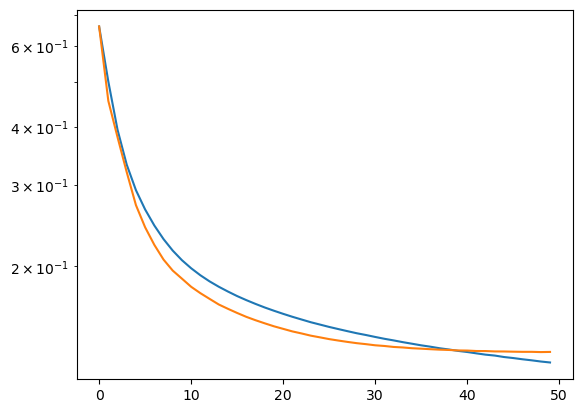

In [35]:
plt.plot(loss_ref)
plt.plot(loss_predict)
plt.yscale('log')

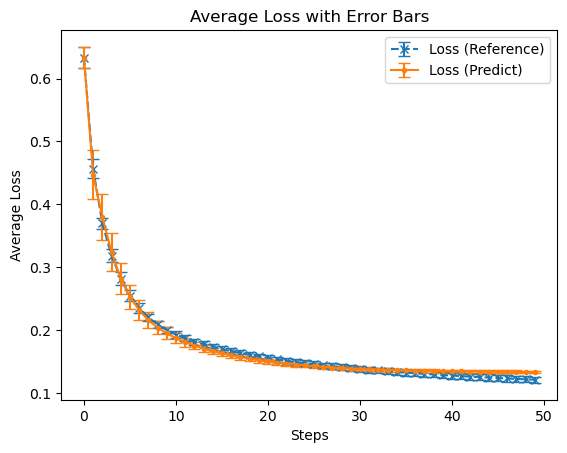

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the average and standard deviation of loss for each step
average_loss_ref = np.mean(loss_ref_set, axis=0)
std_loss_ref = np.std(loss_ref_set, axis=0)
average_loss_predict = np.mean(loss_predict_set, axis=0)
std_loss_predict = np.std(loss_predict_set, axis=0)

# Create an array for the steps
steps = np.arange(steps_num)

# Plot the average loss with error bars
plt.errorbar(steps, average_loss_ref, yerr=std_loss_ref, label='Loss (Reference)', capsize=4, linestyle='--', marker='x')
plt.errorbar(steps, average_loss_predict, yerr=std_loss_predict, label='Loss (Predict)', capsize=4, linestyle='-', marker='.')

# Customize the plot
plt.title('Average Loss with Error Bars')
plt.xlabel('Steps')
plt.ylabel('Average Loss')
plt.legend()
# plt.grid(True)

# Show the plot
plt.show()


In [34]:
import numpy as np

average_loss_ref_filename = 'average_loss_ref' + suffix + '.npy'
std_loss_ref_filename = 'std_loss_ref' + suffix + '.npy'
average_loss_predict_filename = 'average_loss_predict' + suffix + '.npy'
std_loss_predict_filename = 'std_loss_predict' + suffix + '.npy'

np.save(average_loss_ref_filename, average_loss_ref)
np.save(std_loss_ref_filename, std_loss_ref)
np.save(average_loss_predict_filename, average_loss_predict)
np.save(std_loss_predict_filename, std_loss_predict)

print("Arrays saved to files with the suffix:", suffix)


Arrays saved to files with the suffix: _16node_128latent_1step
